# Bayesian Parametric Regression

    Notebook version: 1.4 (Sep 22, 2018)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid-Sueiro (jesus.cid@uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - ML Model selection included
             v.1.2 - Some typos corrected
             v.1.3 - Rewriting text, reorganizing content, some exercises.
             v.1.4 - Revised introduction
    
    Pending changes: * Include regression on the stock data

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 
from IPython import display
 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab
import time

## A quick note on the mathematical notation

In this notebook we will make extensive use of probability distributions. In general, we will use capital leters
${\bf X}$, $S$, $E$ ..., to denote random variables, and lower-case letters ${\bf x}$, $s$, $\epsilon$ ..., to denote the values they can take. 

In general, we will use letter $p$ for probability density functions (pdf). When necessary, we will use, capital subindices to make the random variable explicit. For instance, $p_{{\bf X}, S}({\bf x}, s)$ would be the joint pdf of random variables ${\bf X}$ and $S$ at values ${\bf x}$ and $s$, respectively. 

However, to avoid a notation overload, we will omit subindices when they are clear from the context. For instance, we will use $p({\bf x}, s)$ instead of $p_{{\bf X}, S}({\bf x}, s)$.

## 1. Model-based parametric regression

### 1.1. The regression problem.

Given an observation vector ${\bf x}$, the goal of the regression problem is to find a function $f({\bf x})$ providing *good* predictions about some unknown variable $s$. To do so, we assume that a set of *labelled* training examples, $\{{\bf x}^{(k)}, s^{(k)}\}_{k=1}^K$ is available. 

The predictor function should make good predictions for new observations ${\bf x}$ not used during training. In practice, this is tested using a second set (the *test set*) of labelled samples.

### 1.2. Model-based parametric regression

Model-based regression methods assume that all data in the training and test dataset have been generated by some stochastic process. In parametric regression, we assume that the probability distribution generating the data has a known parametric form, but the values of some parameters are unknown. 

In particular, in this notebook we will assume the target variables in all pairs $({\bf x}^{(k)}, s^{(k)})$ from the training and test sets have been generated independently from some posterior distribution $p(s| {\bf x}, {\bf w})$, were ${\bf w}$ is some unknown parameter. The training dataset is used to estimate ${\bf w}$. 

<img src="figs/ParametricReg.png", width=300>


### 1.3. Model assumptions

In order to estimate ${\bf w}$ from the training data in a mathematicaly rigorous and compact form let us group the target variables into a vector
$$
{\bf s} = \left(s^{(0)}, \dots, s^{(K-1)}\right)^\top
$$
and the input vectors into a matrix
$$
{\bf X} = \left({\bf x}^{(0)}, \dots, {\bf x}^{(K-1)}\right)^\top
$$

We will make the following assumptions:

   * A1. All samples in ${\cal D}$ have been generated by the same distribution, $p({\bf x}, s \mid {\bf w})$
   * A2. Input variables ${\bf x}$ do not depend on ${\bf w}$. This implies that
$$
p({\bf X} \mid {\bf w}) = p({\bf X})
$$
   * A3. Targets $s^{(0)},\ldots, s^{(K-1)}$ are statistically independent, given ${\bf w}$ and the inputs ${\bf x}^{(0)},\ldots, {\bf x}^{(K-1)}$, that is:
$$
p({\bf s} \mid {\bf X}, {\bf w}) = \prod_{k=0}^{K-1} p(s^{(k)} \mid {\bf x}^{(k)}, {\bf w})
$$
   

## 2. Bayesian inference.

### 2.1. The Bayesian approach

The main idea of Bayesian inference is the following: assume we want to estimate some unknown variable $U$ given an observed variable $O$. If $U$ and $O$ are random variables, we can describe the relation between $U$ and $O$ through the following functions:

   * Prior distribution: $p_U(u)$. It describes our uncertainty on the true value of $U$ before observing $O$.
   * Likelihood function: $p_{O \mid U}(o \mid u)$. It describes how the value of the observation is generated for a given value of $U$.
   * Posterior distribution: $p_{U|O}(u \mid o)$. It describes our uncertainty on the true value of $U$ once the true value of $O$ is observed.

The major component of the Bayesian inference is the posterior distribution. All Bayesian estimates are computed as some of its central statistics (e.g. the mean, the median or the mode), for instance

   * Maximum A Posteriori (MAP) estimate: $\qquad{\widehat{u}}_{\text{MAP}} = \arg\max_u p_{U \mid O}(u \mid o)$
   * Minimum Mean Square Error (MSE) estimate: $\qquad\widehat{u}_{\text{MSE}} = \mathbb{E}\{U \mid O=o\}$

The choice between the MAP or the MSE estimate may depend on practical or computational considerations. From a theoretical point of view, $\widehat{u}_{\text{MSE}}$ has some nice properties: it minimizes $\mathbb{E}\{(U-\widehat{u})^2\}$ among all possible estimates, $\widehat{u}$, so it is a natural choice. However, it involves the computation of an integral, which may not have a closed-form solution. In such cases, the MAP estimate can be a better choice.

The prior and the likelihood function are auxiliary distributions: if the posterior distribution is unknown, it can be computed from them using the Bayes rule:
\begin{equation}
p_{U|O}(u \mid o) = \frac{p_{O|U}(o \mid u) \cdot p_{U}(u)}{p_{O}(o)}
\end{equation}

In the next two sections we show that the Bayesian approach can be applied to both the prediction and the estimation problems.

### 2.2. Bayesian prediction under a known model

Assuming that the model parameters ${\bf w}$ are known, we can apply the Bayesian approach to predict ${\bf s}$ for an input ${\bf x}$. In that case, we can take

   * Unknown variable: ${\bf s}$, and
   * Observations: ${\bf x}$

the MAP and MSE predictions become

* Maximum A Posterior (MAP): $\qquad\widehat{s}_{\text{MAP}} = \arg\max_s p(s| {\bf x}, {\bf w})$
* Minimum Mean Square Error (MSE): $\qquad\widehat{s}_{\text{MSE}} = \mathbb{E}\{S |{\bf x}, {\bf w}\}$


#### Exercise 1:

Assuming 
$$
p(s\mid x, w) = \frac{s}{w x^2} \exp\left({-\frac{s^2}{2 w x^2}}\right), \qquad s \geq 0,
$$
compute the MAP and MSE predictions of $s$ given $x$ and $w$.

#### Solution:
<SOL>
</SOL>

#### 2.2.1. The Gaussian case

A particularly interesting case arises when the data model is Gaussian:

$$p(s|{\bf x}, {\bf w}) = 
    \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{(s-{\bf w}^\top{\bf z})^2}{2\sigma_\varepsilon^2}\right)
$$

where ${\bf z}=T({\bf x})$ is a vector with components which can be computed directly from the observed variables. For a Gaussian distribution (and for any unimodal symetric distributions) the mean and the mode are the same and, thus,

$$
\widehat{s}_\text{MAP} = \widehat{s}_\text{MSE} = {\bf w}^\top{\bf z}
$$


Such expression includes a linear regression model, where ${\bf z} = [1; {\bf x}]$, as well as any other non-linear model as long as it can be expressed as a <i>"linear in the parameters"</i> model.



### 2.3. Bayesian Inference for Parameter Estimation

In a similar way, we can apply Bayesian inference to estimate the model parameters ${\bf w}$ from a given dataset, $\cal{D}$. In that case

   * the unknown variable is ${\bf w}$, and
   * the observation is $\cal{D} \equiv \{{\bf X}, {\bf s}\}$

so that

* Maximum A Posterior (MAP): $\qquad\widehat{\bf w}_{\text{MAP}} = \arg\max_{\bf w} p({\bf w}| {\cal D})$
* Minimum Mean Square Error (MSE): $\qquad\widehat{\bf w}_{\text{MSE}} = \mathbb{E}\{{\bf W} | {\cal D}\}$

## 3. Bayesian parameter estimation

NOTE: Since the training data inputs are known, all probability density functions and expectations in the remainder of this notebook will be conditioned on the data matrix, ${\bf X}$. To simplify the mathematical notation, from now on we will remove ${\bf X}$ from all conditions. For instance, we will write  $p({\bf s}|{\bf w})$ instead of  $p({\bf s}|{\bf w}, {\bf X})$, etc. Keep in mind that, in any case, all probabilities and expectations may depend on ${\bf X}$ implicitely.

Summarizing, the steps to design a Bayesian parametric regresion algorithm are the following:

1. Assume a parametric data model $p(s| {\bf x},{\bf w})$ and a prior distribution $p({\bf w})$.
2. Using the data model and the i.i.d. assumption, compute $p({\bf s}|{\bf w})$.
3. Applying the bayes rule, compute the posterior distribution $p({\bf w}|{\bf s})$.
4. Compute the MAP or the MSE estimate of ${\bf w}$ given ${\bf x}$.
5. Compute predictions using the selected estimate.


### 3.1. Bayesian Inference and Maximum Likelihood.

Applying the Bayes rule the MAP estimate can be alternatively expressed as
\begin{align}
\qquad\widehat{\bf w}_{\text{MAP}} 
   &= \arg\max_{\bf w} \frac{p({\cal D}| {\bf w}) \cdot p({\bf w})}{p({\cal D})} \\
   &= \arg\max_{\bf w} p({\cal D}| {\bf w}) \cdot p({\bf w})
\end{align}

By comparisons, the ML (Maximum Likelihood) estimate has the form:
$$
\widehat{\bf w}_{\text{ML}} = \arg \max_{\bf w} p(\mathcal{D}|{\bf w})
$$

This shows that the MAP estimate takes into account the prior distribution on the unknown parameter.

Another advantage of the Bayesian approach is that it provides not only a point estimate of the unknown parameter, but a whole funtion, the posterior distribution, which encompasses our belief on the unknown parameter given the data. For instance, we can take second order statistics like the variance of the posterior distributions to measure the uncertainty on the true value of the parameter around the mean.

### 3.2. The prior distribution

Since each value of ${\bf w}$ determines a regression function, by stating a prior distribution over the weights we state also a prior distribution over the space of regression functions.

For instance, assume that the data likelihood follows the Gaussian model in sec. 2.2.1, with $T(x) = (1, x, x^2, x^3)$, i.e. the regression functions have the form
$$
w_0 + w_1 x + w_2 x^2 + w_3 x^3
$$

Each value of ${\bf w}$ determines a specific polynomial of degree 3. Thus, the prior distribution over ${\bf w}$ describes which polynomials are more likely before observing the data.

For instance, assume a Gaussian prior with zero mean and variance ${\bf V}_p$, i.e.,
$$
p({\bf w}) = \frac{1}{(2\pi)^{D/2} |{\bf V}_p|^{1/2}} 
              \exp \left(-\frac{1}{2} {\bf w}^\intercal {\bf V}_{p}^{-1}{\bf w} \right)
$$
where $D$ is the dimension of ${\bf w}$. To abbreviate, we will also express this as
$${\bf w} \sim {\cal N}\left({\bf 0},{\bf V}_{p} \right)$$
The following code samples ${\bf w}$ according to this distribution for ${\bf V}_p = 0.002 \, {\bf I}$, and plots the resulting polynomial over the scatter plot of an arbitrary dataset.

You can check the effect of modifying the variance of the prior distribution.

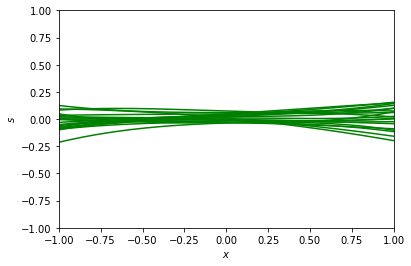

In [2]:
n_grid = 200
degree = 3
nplots = 20

# Prior distribution parameters
mean_w = np.zeros((degree+1,))
v_p = 0.002     ### Try increasing this value
var_w = v_p * np.eye(degree+1)

xmin = -1
xmax = 1
X_grid = np.linspace(xmin, xmax, n_grid)

fig = plt.figure()
ax = fig.add_subplot(111)

for k in range(nplots):
    
    #Draw weigths fromt the prior distribution
    w_iter = np.random.multivariate_normal(mean_w, var_w)
    S_grid_iter = np.polyval(w_iter, X_grid)
    ax.plot(X_grid, S_grid_iter,'g-')

ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$s$')
plt.show()

The data observation will modify our belief about the true data model according to the posterior distribution. In the following we will analyze this in a Gaussian case.

## 4. Bayesian regression for a Gaussian model.

We will apply the above steps to derive a Bayesian regression algorithm for a Gaussian model.

### 4.1. Step 1: The Gaussian model.

Let as assume that the likelihood function is given by the Gaussian model described in Sec. 1.3.2.

$$
s~|~{\bf w} \sim {\cal N}\left({\bf z}^\top{\bf w}, \sigma_\varepsilon^2 \right)
$$

that is 
$$p(s|{\bf x}, {\bf w}) = 
    \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{(s-{\bf w}^\top{\bf z})^2}{2\sigma_\varepsilon^2}\right)
$$

Assume, also, that the prior is Gaussian

$$
{\bf w} \sim {\cal N}\left({\bf 0},{\bf V}_{p} \right)
$$

### 4.2. Step 2: Complete data likelihood

Using the assumptions A1, A2 and A3, it can be shown that

$$
{\bf s}~|~{\bf w} \sim {\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)
$$
that is
$$
p({\bf s}| {\bf w})
    = \frac{1}{\left(\sqrt{2\pi}\sigma_\varepsilon\right)^K}
      \exp\left(-\frac{1}{2\sigma_\varepsilon^2}\|{\bf s}-{\bf Z}{\bf w}\|^2\right)
$$



### 4.3. Step 3: Posterior weight distribution

The posterior distribution of the weights can be computed using the Bayes rule

$$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$

Since both $p({\bf s}|{\bf w})$ and $p({\bf w})$ follow a Gaussian distribution, we know also that the joint distribution and the posterior distribution of ${\bf w}$ given ${\bf s}$ are also Gaussian. Therefore,

$${\bf w}~|~{\bf s} \sim {\cal N}\left({\bf w}_\text{MSE}, {\bf V}_{\bf w}\right)$$

After some algebra, it can be shown that mean and the covariance matrix of the distribution are:

$${\bf V}_{\bf w} = \left[\frac{1}{\sigma_\varepsilon^2} {\bf Z}^{\top}{\bf Z} 
                  + {\bf V}_p^{-1}\right]^{-1}$$

$${\bf w}_\text{MSE} = {\sigma_\varepsilon^{-2}} {\bf V}_{\bf w} {\bf Z}^\top {\bf s}$$

#### Exercise 1: 

Consider the dataset with one-dimensional inputs given by

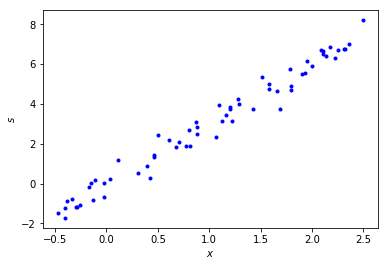

In [3]:
# True data parameters
w_true = 3
std_n = 0.4

# Generate the whole dataset
n_max = 64
X_tr = 3 * np.random.random((n_max,1)) - 0.5
S_tr =  w_true * X_tr + std_n * np.random.randn(n_max,1)

# Plot data
plt.figure()
plt.plot(X_tr, S_tr, 'b.')
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.show()

Fit a Bayesian linear regression model assuming ${\bf z}={\bf x}$ and

In [4]:
# Model parameters
sigma_eps = 0.4
mean_w = np.zeros((1,))
sigma_p = 1e6
Var_p = sigma_p**2* np.eye(1)

To do so, compute the posterior weight distribution using the first $k$ samples in the complete dataset, for $k = 1,2,4,8,\ldots 128$. Draw all these posteriors along with the prior distribution in the same plot.

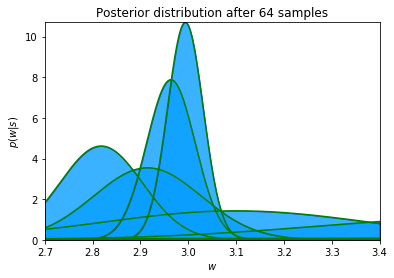

In [5]:
# No. of points to analyze
n_points = [1, 2, 4, 8, 16, 32, 64]

# Prepare plots
w_grid = np.linspace(2.7, 3.4, 5000)   # Sample the w axis
plt.figure()

# Compute the prior distribution over the grid points in w_grid
# p = <FILL IN>
plt.plot(w_grid, p,'g-')

for k in n_points:

    # Select the first k samples
    Zk = X_tr[0:k, :]
    Sk = S_tr[0:k]

    # Parameters of the posterior distribution
    # 1. Compute the posterior variance.
    #    (Make sure that the resulting variable, Var_w, is a 1x1 numpy array.)
    # Var_w = <FILL IN>

    # 2. Compute the posterior mean.
    #    (Make sure that the resulting variable, w_MSE, is a scalar)
    # w_MSE = <FILL IN>

    # Compute the posterior distribution over the grid points in w_grid
    sigma_w = np.sqrt(Var_w.flatten())     # First we take a scalar standard deviation
    # p = <FILL IN>
    
    plt.plot(w_grid, p,'g-')
    plt.fill_between(w_grid, 0, p, alpha=0.8, edgecolor='#1B2ACC', facecolor='#089FFF',
        linewidth=1, antialiased=True)
    plt.title('Posterior distribution after {} samples'.format(k))
    plt.xlim(w_grid[0], w_grid[-1])
    plt.ylim(0, np.max(p))
    plt.xlabel('$w$')
    plt.ylabel('$p(w|s)$')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2.0)

# Remove the temporary plots and fix the last one
display.clear_output(wait=True)
plt.show()

#### Exercise 2: 

Note that, in the example above, the model assumptions are correct: the target variables have been generated by a linear model with noise standard deviation `sigma_n` which is exactly equal to the value assumed by the model, stored in variable `sigma_eps`. Check what happens if we take `sigma_eps=4*sigma_n` or `sigma_eps=sigma_n/4`. 

* Does the algorithm fail in that cases?
* What differences can you observe with respect to the ideal case `sigma_eps=sigma_n`?

### 4.4. Step 4: Weight estimation.

Since the posterior weight distribution is Gaussian, both the MAP and the MSE estimates are equal to the posterior mean, which has been already computed in step 3:

$$\widehat{\bf w}_\text{MAP} = \widehat{\bf w}_\text{MSE} = {\sigma_\varepsilon^{-2}} {\bf V}_{\bf w} {\bf Z}^\top {\bf s}$$

### 4.5. Step 5: Prediction

Using the MSE estimate, the final predictions are given by
$$
\widehat{s}_\text{MSE} =  \widehat{\bf w}_\text{MSE}^\top{\bf z}
$$

#### Exercise 3:

Plot the minimum MSE predictions of $s$ for inputs $x$ in the interval [-1, 3].

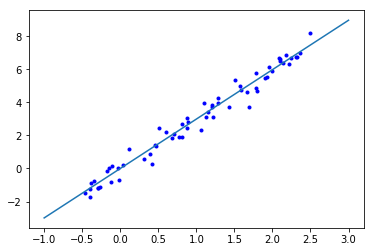

In [6]:
# <SOL>
# </SOL>

## 5. Maximum likelihood vs Bayesian Inference.  

### 5.1. The Maximum Likelihood Estimate.

For comparative purposes, it is interesting to see here that the likelihood function is enough to compute the Maximum Likelihood (ML) estimate 

\begin{align}
{\bf w}_\text{ML} &= \arg \max_{\bf w} p(\mathcal{D}|{\bf w}) \\
             &= \arg \min_{\bf w} \|{\bf s}-{\bf Z}{\bf w}\|^2
\end{align}
which leads to the Least Squares (LS) solution
$$
{\bf w}_\text{ML} = ({\bf Z}^\top{\bf Z})^{-1}{\bf Z}^\top{\bf s}
$$

ML estimation is prone to overfiting. In general, if the number of parameters (i.e. the dimension of ${\bf w}$) is large in relation to the size of the training data, the predictor based on the ML estimate may have a small square error over the training set but a large error over the test set. Therefore, in practice, some cross validation procedure is required to keep the complexity of the predictor function under control depending on the size of the training set.

By defining a prior distribution over the unknown parameters, and using the Bayesian inference methods, the overfitting problems can be alleviated


### 5.2 Making predictions

   - Following an <b>ML approach</b>, we retain a single model, ${\bf w}_{ML} = \arg \max_{\bf w} p({\bf s}|{\bf w})$. Then, the predictive distribution of the target value for a new point would be obtained as:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) $$
   
   For the generative model of Section 3.1.2 (additive i.i.d. Gaussian noise), this distribution is:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) = \frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}_{ML}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$$
   
      * The mean of $s^*$ is just the same as the prediction of the LS model, and the same uncertainty is assumed independently of the observation vector (i.e., the variance of the noise of the model).
      
      * If a single value is to be kept, we would probably keep the mean of the distribution, which is equivalent to the LS prediction.
   
   
   - Using <b>Bayesian inference</b>, we retain all models. Then, the inference of the value $s^* = s({\bf x}^*)$ is carried out by mixing all models, according to the weights given by the posterior distribution.
   
   \begin{align}p({s^*}|{\bf x}^*,{\bf s}) 
                         & = \int p({s^*}~|~{\bf w},{\bf x}^*) p({\bf w}~|~{\bf s}) d{\bf w}\end{align}
   
   where:
   
      * $p({s^*}|{\bf w},{\bf x}^*) = \displaystyle\frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$
      * $p({\bf w}~|~{\bf s})$: Is the posterior distribution of the weights, that can be computed using Bayes' Theorem.
      
In general the integral expression of the posterior distribution $p({s^*}|{\bf x}^*,{\bf s})$ cannot be computed analytically. Fortunately, for the Gaussian model, the computation of the posterior is simple, as we will show in the following section.


## 6. Posterior distribution of the target variable

In the same way that we have computed a distribution on ${\bf w}$, we can compute a distribution on the target variable for a given input ${\bf x}$ and given the whole dataset.

Since ${\bf w}$ is a random variable, the noise-free component of the target variable for an arbitrary input ${\bf x}$, that is, $f = f({\bf x}) = {\bf w}^\top{\bf z}$ is also a random variable, and we can compute its distribution from the posterior distribution of ${\bf w}$

Since ${\bf w}$ is Gaussian and $f$ is a linear transformation of ${\bf w}$, $f$ is also a Gaussian random variable, whose posterior mean and variance can be calculated as follows:

\begin{align}
\mathbb{E}\{f \mid {\bf s}, {\bf z}\} 
   &= \mathbb{E}\{{\bf w}^\top {\bf z}~|~{\bf s}, {\bf z}\}  
    = \mathbb{E}\{{\bf w} ~|~{\bf s}, {\bf z}\}^\top  {\bf z}    \\
   &=  \widehat{\bf w}_\text{MSE} ^\top {\bf z}     \\
%   &=  {\sigma_\varepsilon^{-2}} {{\bf z}}^\top {\bf V}_{\bf w} {\bf Z}^\top {\bf s}
\end{align}

\begin{align}
\text{Cov}\left[{{\bf z}}^\top {\bf w}~|~{\bf s}, {\bf z}\right] 
   &= {\bf z}^\top \text{Cov}\left[{\bf w}~|~{\bf s}\right] {\bf z}    \\
   &= {\bf z}^\top {\bf V}_{\bf w} {{\bf z}}
\end{align}
   
Therefore, 
$$
f^*~|~{\bf s}, {\bf x} 
   \sim {\cal N}\left(\widehat{\bf w}_\text{MSE} ^\top {\bf z}, ~~ 
                      {\bf z}^\top {\bf V}_{\bf w} {\bf z} \right)
$$
   
Finally, for $s = f + \varepsilon$, the posterior distribution is  
$$
s ~|~{\bf s}, {\bf z}^* 
   \sim {\cal N}\left(\widehat{\bf w}_\text{MSE} ^\top {\bf z}, ~~
                      {\bf z}^\top {\bf V}_{\bf w} {\bf z} + \sigma_\varepsilon^2\right)
$$


#### Example:

The next figure shows a one-dimensional dataset with 15 points, which are noisy samples from a cosine signal (shown in the dotted curve)

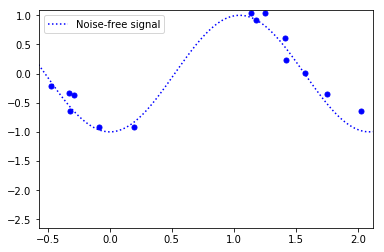

In [7]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2

# Data generation
X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

# Signal
xmin = np.min(X_tr) - 0.1
xmax = np.max(X_tr) + 0.1
X_grid = np.linspace(xmin, xmax, n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

# Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z = np.asmatrix(Z)

# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

# Plot noise-free function
ax.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    

# Set axes
ax.set_xlim(xmin, xmax)
ax.set_ylim(S_tr[0] - 2, S_tr[-1] + 2)
ax.legend(loc='best')
plt.show()

Let us asssume that the cosine form of the noise-free signal is unknown, and we assume a polynomial model with a high degree. The following code plots the LS estimate

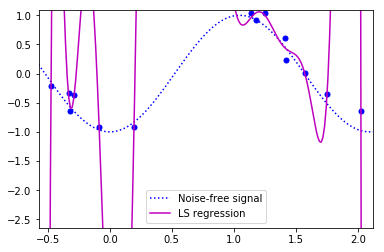

In [8]:
degree = 12

# We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_LS = np.polyval(w_LS,X_grid)

# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

# Plot noise-free function
ax.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot LS regression function
ax.plot(X_grid, S_grid_LS, 'm-', label='LS regression')    

# Set axis
ax.set_xlim(xmin, xmax)
ax.set_ylim(S_tr[0] - 2, S_tr[-1] + 2)
ax.legend(loc='best')
plt.show()

The following fragment of code computes the posterior weight distribution, draws random vectors from $p({\bf w}|{\bf s})$, and plots the corresponding regression curves along with the training points. Compare these curves with those extracted from the prior distribution of ${\bf w}$ and with the LS solution.

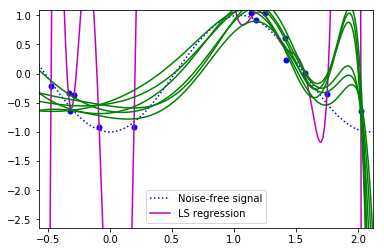

In [9]:
nplots = 6

# Prior distribution parameters
sigma_eps = 0.2
mean_w = np.zeros((degree+1,))
sigma_p = .5
Var_p = sigma_p**2 * np.eye(degree+1)

# Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z = np.asmatrix(Z)

#Compute posterior distribution parameters
Var_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(Var_p))
posterior_mean = Var_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

# Plot noise-free function
ax.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot LS regression function
ax.plot(X_grid, S_grid_LS, 'm-', label='LS regression')    

for k in range(nplots):
    
    # Draw weights from the posterior distribution
    w_iter = np.random.multivariate_normal(posterior_mean, Var_w)

    # Note that polyval assumes the first element of weight vector is the coefficient of
    # the highest degree term. Thus, we need to reverse w_iter
    S_grid_iter = np.polyval(w_iter[::-1], X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

# Set axis
ax.set_xlim(xmin, xmax)
ax.set_ylim(S_tr[0] - 2, S_tr[-1] + 2)
ax.legend(loc='best')
plt.show()

Not only do we obtain a better predictive model, but we also have confidence intervals (error bars) for the predictions.

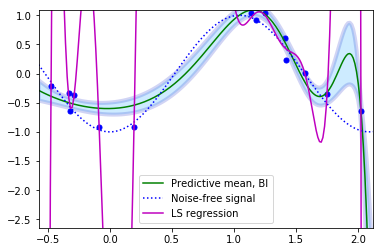

In [10]:
# Compute standard deviation
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Var_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)

# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

# Plot the posterior mean
# Note that polyval assumes the first element of weight vector is the coefficient of
# the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)

# Plot noise-free function
ax.plot(X_grid, S_grid, 'b:', label='Noise-free signal')    
# Plot LS regression function
ax.plot(X_grid, S_grid_LS, 'm-', label='LS regression')    

# Set axis
ax.set_xlim(xmin, xmax)
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.legend(loc='best')
plt.show()

#### Exercise 4:

Assume the dataset ${\cal{D}} = \left\{ x^{(k)}, s^{(k)}\right\}_{k=0}^{K-1}$ containing $K$ i.i.d. samples from a distribution

$\qquad p(s|x,w) = w x \exp(-w x s), \; s>0, x> 0, w> 0$

We model also our uncertainty about the value of $w$ assuming a prior distribution for $w$ following a Gamma distribution with parameters $\alpha>0$ and $\beta>0$.

$ \qquad
w \sim \text{Gamma}\left(\alpha, \beta\right) = \frac{\beta^\alpha}{\Gamma(\alpha)} w^{\alpha-1} \exp\left(-\beta w\right), \; w>0
$

Note that the mean and the mode of a Gamma distribution can be calculated in closed-form as
$\qquad w_\text{MSE} = \mathbb{E}\left\{w\right\}=\frac{\alpha}{\beta}; \qquad
w_\text{MAP} = \max_w p(w) = \frac{\alpha-1}{\beta}$

**1.** Determine an expression for the likelihood function.

**2.** Determine the maximum likelihood coefficient,  $\widehat{w}_{\text{ML}}$.

**3.** Obtain the posterior distribution $p(w|{\bf s})$. Note that you do not need to calculate $p({\bf s})$ since the posterior distribution can be readily identified as another Gamma distribution.

**4.** Determine the MSE and MAP a posteriori estimators of $w$: $w_\text{MSE}=\mathbb{E}\left\{w|{\bf s}\right\}$ and $w_\text{MAP} = \max_w p(w|{\bf s})$.

**5.** Compute the following estimators of $S$:

$\qquad\widehat{s}_1 = \mathbb{E}\{s|w_\text{ML},x\}$

$\qquad\widehat{s}_2 = \mathbb{E}\{s|w_\text{MSE},x\}$

$\qquad\widehat{s}_3 = \mathbb{E}\{s|w_\text{MAP},x\}$

## 7. Maximum evidence model selection

We have already addressed with Bayesian Inference the following two issues:

   - For a given degree, how do we choose the weights?
   
   - Should we focus on just one model, or can we use several models at once?
   
However, we still needed some assumptions: a parametric model (i.e., polynomial function and <i>a priori</i> degree selection) and several parameters needed to be adjusted.

Though we can recur to cross-validation, Bayesian inference opens the door to other strategies. 

   - We could argue that rather than keeping single selections of these parameters, we could use simultaneously several sets of parameters (and/or several parametric forms), and average them in a probabilistic way ... (like we did with the models)
   
   - We will follow a simpler strategy, selecting just the most likely set of parameters according to an ML criterion

### 7.1 Model evidence

The evidence of a model is defined as

$$L = p({\bf s}~|~{\cal M})$$

where ${\cal M}$ denotes the model itself and any free parameters it may have. For instance, for the polynomial model we have assumed so far, ${\cal M}$ would represent the degree of the polynomia, the variance of the additive noise, and the <i>a priori</i> covariance matrix of the weights

Applying the Theorem of Total probability, we can compute the evidence of the model as

$$L = \int p({\bf s}~|~{\bf f},{\cal M}) p({\bf f}~|~{\cal M}) d{\bf f} $$

For the linear model $f({\bf x}) = {\bf w}^\top{\bf z}$, the evidence can be computed as

$$L = \int p({\bf s}~|~{\bf w},{\cal M}) p({\bf w}~|~{\cal M}) d{\bf w} $$

It is important to notice that these probability density functions are exactly the ones we computed on the previous section. We are just making explicit that they depend on a particular model and the selection of its parameters. Therefore:

   - $p({\bf s}~|~{\bf w},{\cal M})$ is the likelihood of ${\bf w}$
   
   - $p({\bf w}~|~{\cal M})$ is the <i>a priori</i> distribution of the weights

### 7.2 Model selection via evidence maximization

   - As we have already mentioned, we could propose a prior distribution for the model parameters, $p({\cal M})$, and use it to infer the posterior. However, this can be very involved (usually no closed-form expressions can be derived)
   
   - Alternatively, maximizing the evidence is normally good enough
   
   $${\cal M}_\text{ML} = \arg\max_{\cal M} p(s~|~{\cal M})$$
   
Note that we are using the subscript 'ML' because the evidence can also be referred to as the likelihood of the model

### 7.3 Example: Selection of the degree of the polynomia

For the previous example we had (we consider a spherical Gaussian for the weights):

   - ${\bf s}~|~{\bf w},{\cal M}~\sim~{\cal N}\left({\bf Z}{\bf w},~\sigma_\varepsilon^2 {\bf I} \right)$
   
   - ${\bf w}~|~{\cal M}~\sim~{\cal N}\left({\bf 0},~\sigma_p^2 {\bf I} \right)$
   
In this case, $p({\bf s}~|~{\cal M})$ follows also a Gaussian distribution, and it can be shown that

   - $L = p({\bf s}~|~{\cal M}) = {\cal N}\left({\bf 0},\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I} \right)$
   
If we just pursue the maximization of $L$, this is equivalent to maximizing the log of the evidence

$$\log(L) = -\frac{M}{2} \log(2\pi) -{\frac{1}{2}}\log\mid\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\mid - \frac{1}{2} {\bf s}^\top \left(\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\right)^{-1} {\bf s}$$

where $M$ denotes the length of vector ${\bf z}$ (the degree of the polynomia minus 1).
   
The following fragment of code evaluates the evidence of the model as a function of the degree of the polynomia

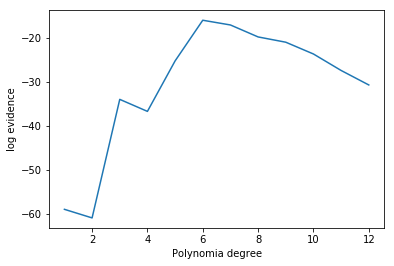

In [11]:
from math import pi

n_points = 15
frec = 3
std_n = 0.2
max_degree = 12

#Prior distribution parameters
sigma_eps = 0.2
mean_w = np.zeros((degree+1,))
sigma_p = 0.5

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Evaluate the posterior evidence

logE = []
for deg in range(max_degree):
    Z_iter = Z[:,:deg+1]
    logE_iter = -((deg+1)*np.log(2*pi)/2) \
                -np.log(np.linalg.det((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points)))/2 \
                -S_tr.T.dot(np.linalg.inv((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points))).dot(S_tr)/2
    logE.append(logE_iter[0,0])

plt.plot(np.array(range(max_degree))+1,logE)
plt.xlabel('Polynomia degree')
plt.ylabel('log evidence')
plt.show()


The above curve may change the position of its maximum from run to run.

We conclude the notebook by plotting the result of the Bayesian inference for M=6

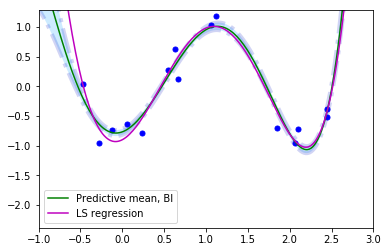

In [12]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 5 #M-1
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .5 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-1,3,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

#Plot the posterior mean
#Note that polyval assumes the first element of weight vector is the coefficient of
#the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Sigma_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-1,3)
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.legend(loc='best')
plt.show()

We can check, that now the model also seems quite appropriate for LS regression, but keep in mind that selection of such parameter was itself carried out using Bayesian inference.